In [1]:
import sys
sys.path.append("..")
import os, pickle, scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
from tqdm import tqdm_notebook as tqdm
# from coh_tools import *
from joblib import Parallel, delayed
import h5py
import nitime.timeseries as ts
import nitime.analysis as nta

%matplotlib inline

In [2]:
os.chdir("/mnt/hdd2tb/lab/elife/data")
# os.chdir(r"C:\Users\julienb\lab\data")

In [3]:
experiments = pd.read_csv('table_of_experiments.csv')

In [4]:
stim_experiments = experiments #.loc[experiments["stim_Coh_from"] != 0]

In [5]:
stim_experiments.head()

Experiment   Monkey  YYYYMMDD   Session PREAMP  \
0  Experiment1  MonkeyG  20150908  Session2     M1   
1  Experiment2  MonkeyG  20150908  Session3     M1   
2  Experiment3  MonkeyG  20150908  Session4     M1   
3  Experiment4  MonkeyG  20150909  Session2     M1   
4  Experiment5  MonkeyG  20150909  Session3     M1   

                          File Name  stim_Coh_from  stim_Coh_to  \
0  MonkeyG_20150908_Session2_M1.zip             46           63   
1  MonkeyG_20150908_Session3_M1.zip             48           43   
2  MonkeyG_20150908_Session4_M1.zip             48           16   
3  MonkeyG_20150909_Session2_M1.zip             48           12   
4  MonkeyG_20150909_Session3_M1.zip             53           27   

   Number of Lasers in Experiment  Number of Lasers during Conditioning Delay  \
0                               2                                     2  10ms   
1                               2                                     2  10ms   
2                               2                                     2  10ms   
3                               2                                     2  10ms   
4                               2                                     2  10ms   

                                            m1_sites  \
0  1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...   
1  1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...   
2  1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...   
3  1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,2,4...   
4  1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,2,4...   

                                            s1_sites  
0  50,52,54,56,57,58,59,60,61,62,63,64,65,66,67,6...  
1  50,52,54,56,57,58,59,60,61,62,63,64,65,66,67,6...  
2  50,52,54,56,57,58,59,60,61,62,63,64,65,66,67,6...  
3  10,33,34,35,36,37,54,56,57,58,59,60,61,62,63,6...  
4  10,33,34,35,36,37,54,56,57,58,59,60,61,62,63,6...

In [6]:
stim_experiments_list = stim_experiments["File Name"].tolist()
stim_experiments_list = [name[:-4] for name in stim_experiments_list]

## Structure of coherence data:
One dictionary for each session. Keywords are rec1, stim1, etc., and each contain data as [times, 96, 96, freqs]

In [7]:
## Load for joblib

def extract_lfp(filename, want_fs=False):
    f = h5py.File(filename, 'r')
    keys = list(f.keys())
    keys.sort()
    i = 0
    make_signals = True
    for key in keys:
        if key.startswith('lfp'):
            if make_signals:
                signals = np.zeros((96, f[key].size))
                make_signals = False
            signals[i] = f[key][0]
            i += 1
    if want_fs:
        signals = (signals, f['samp_freq'][0,0])
    return signals

def timefreq_granger(signals, sample_frequency, partition_seconds=20, want_f=False):
    partition_size = partition_seconds * sample_frequency
    num_partitions = int(signals.shape[1] // partition_size)
    num_channels = signals.shape[0]
    
    ij = []
    for i in range(num_channels):
        for j in range(num_channels):
            if i != j:
                ij.append((i, j))
    
    timefreq_mm = []
    for partition_i in range(num_partitions):
        partition = signals[:, partition_i*(int(partition_size)):(partition_i+1)*(int(partition_size))]
                    
        time_series = ts.TimeSeries(partition, sampling_rate=sample_frequency)
        G = nta.GrangerAnalyzer(time_series, order=10, ij=ij)
        Gxy = np.nan_to_num(G.causality_xy)
        freqs = G.frequencies
                
        Gxy += np.dstack([np.identity(num_channels)]*freqs.shape[0])
        
        timefreq_mm.append(Gxy)
    timefreq_mm = np.array(timefreq_mm)
    if want_f:
            return (timefreq_mm, freqs)   
    return timefreq_mm

def get_freq_band_indices(frequencies, low, high):
    first = True
    for i in range(len(frequencies)):
        if first and frequencies[i] > low:
            low_index = i
            first = False
        if frequencies[i] > high:
            high_index = i
            break
    return [low_index, high_index]

In [8]:
def joblib_granger(experiment_i):
    session_data_dict = {}
    
    experiment = stim_experiments_list[experiment_i]
    file_location = experiment + "/RecordingBlocks/"
    first = True
    file_list = os.listdir(file_location)
    file_list.sort()
    stim_index = 1

    for filename in file_list:

        if not filename.endswith(".mat"):
            continue
        baseline_filename = file_location + filename
        savenamebase = experiment[:-3] + filename[:-4]

        data, sample_freq = extract_lfp(baseline_filename, True)

        all_band_coherences, freqs = timefreq_granger(data, sample_freq, want_f=True)
        
        low_index, high_index = get_freq_band_indices(freqs, 0, 200)
        
        session_data_dict[baseline_filename.split('/')[-1][0:-4]] = all_band_coherences[:,:,:,low_index:high_index]
        
        if not first:
            stim_filename = baseline_filename.replace("Recording", "Conditioning").\
                replace("RecBlock"+str(stim_index+1), "CondBlock"+str(stim_index))
            stim_data = extract_lfp(stim_filename)
            all_stim_coh = timefreq_granger(stim_data, sample_freq)
            session_data_dict[stim_filename.split('/')[-1][0:-4]] = all_stim_coh[:,:,:,low_index:high_index]

            stim_index += 1

        first = False
#         break
#     print(freqs[0])
#     print(freqs[-1])
#     pkl.dump(session_data_dict, open("../pickled/test", "wb"))
    pkl.dump(session_data_dict,open("/mnt/hdd2tb/lab/elife/data/pickled/20sec_allsession_granger/"+experiment, 'wb'))
#     break
    return
    

In [9]:
Parallel(n_jobs=2)(delayed(joblib_granger)(experiment_i) for experiment_i in tqdm(range(41,len(stim_experiments_list))))



[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [10]:
break

SyntaxError: 'break' outside loop (<ipython-input-10-6aaf1f276005>, line 4)

In [14]:
## Get frequencies
experiment = stim_experiments_list[1]
file_location = experiment + "/RecordingBlocks/"
first = True
file_list = os.listdir(file_location)
file_list.sort()
stim_index = 1

for filename in file_list:

    if not filename.endswith(".mat"):
        continue
    baseline_filename = file_location + filename
    savenamebase = experiment[:-3] + filename[:-4]

    data, sample_freq = extract_lfp(baseline_filename, True)

    all_band_coherences, freqs = timefreq_granger(data, sample_freq, want_f=True)
    break


In [11]:
test = pkl.load(open("/mnt/hdd2tb/lab/elife/data/pickled/20sec_allsession_granger/MonkeyG_20150910_Session3_S1", "rb"))

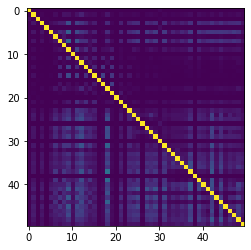

In [12]:
plt.imshow(test["RecBlock1"][0, :50, :50].mean(-1))

In [16]:
test["RecBlock1"].shape

(1, 96, 96, 201)

In [15]:
get_freq_band_indices(freqs, 0, 200)

[1, 202]

In [ ]:
freqs[403]

In [ ]:
sample_freq

In [ ]:
session_data_dict.keys()

In [ ]:
session_data_dict['CondBlock5'].shape

In [ ]:
session_data_dict['CondBlock5'][0,0,0,:]

In [19]:
pkl.dump(freqs[1:202],open("/mnt/hdd2tb/lab/elife/data/pickled/20sec_allsession_granger/freqs.pkl", 'wb'))


In [17]:
freqs[1:202].shape

(201,)